In [1]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [2]:
import os
import re
import random
from argparse import Namespace

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import torchaudio
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import sentencepiece as spm

from sentence_transformers import SentenceTransformer

import sacrebleu
import sentencepiece

import textgrids

from fairseq import utils
from fairseq.data import encoders
from fairseq.data import Dictionary, data_utils as fairseq_data_utils
from fairseq.models.mST.w2v2_transformer import W2V2Transformer
from fairseq.data.audio.multilingual_triplet_align_adv_v2_dataset import (
    MultilingualTripletDataConfig,
    MultilingualTripletDataset,
    MultilingualTripletDatasetCreator
)
from examples.speech_recognition.data.data_utils import padding_mask_to_lengths
from fairseq.data.audio.speech_to_text_dataset import get_features_or_waveform, _collate_frames
from examples.speech_to_text.data_utils import load_df_from_tsv, save_df_to_tsv
from fairseq.checkpoint_utils import load_checkpoint_to_cpu, save_state, torch_persistent_save


In [3]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 
matplotlib.rcParams['font.family'] ='sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

In [4]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [5]:
data_root = '/mnt/data/siqiouyang/datasets/covost2'

In [6]:
langs = ['de', 'fr', 'es', 'it', 'ru', 'zh-CN', 'pt', 'fa', 'et', 'mn', 'nl', 'tr', 'ar', 'sv-SE', 'lv', 'sl', 'ta', 'ja', 'id']

# Load Checkpoints

In [7]:
args = Namespace()
task = Namespace()
def load_dict(vocab_filename):
    _dict_path = vocab_filename
    if not os.path.isfile(_dict_path):
        raise FileNotFoundError(f"Dict not found: {_dict_path}")
    _dict = Dictionary.load(_dict_path)
    for code in codes:
        _dict.add_symbol(MultilingualTripletDataset.LANG_TAG_TEMPLATE.format(code))
    _dict.add_symbol('<mask>')
    return _dict
lang_list_filename = '/mnt/data/siqiouyang/runs/mST/pretrained/mbart50.ft.n1/ML50_langs.txt'
vocab_filename = '/mnt/data/siqiouyang/runs/mST/pretrained/mbart50.ft.n1/dict.txt'
codes = MultilingualTripletDataset.get_lang_codes(lang_list_filename)
dict = load_dict(vocab_filename)
task.src_dict = task.tgt_dict = dict
args.w2v2_model_path = '/mnt/data/siqiouyang/runs/mST/pretrained/xlsr2_300m.pt'
args.mbart50_dir = '/mnt/data/siqiouyang/runs/mST/pretrained/mbart50.ft.n1'
st_model = W2V2Transformer.build_model(args, task)

In [8]:
st_model_tag = 'XSTNet'

In [9]:
ckpt_path = '/mnt/data/siqiouyang/runs/mST/{}/checkpoint_avg.pt'.format(st_model_tag)
ckpt = load_checkpoint_to_cpu(ckpt_path)
st_model.load_state_dict(ckpt["model"], strict=False)
st_model = st_model.to('cuda')
st_model.eval()

W2V2Transformer(
  (encoder): W2V2TransformerEncoder(
    (w2v2_model): Wav2Vec2Model(
      (feature_extractor): ConvFeatureExtractionModel(
        (conv_layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
            (1): Dropout(p=0.0, inplace=False)
            (2): Sequential(
              (0): TransposeLast()
              (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (2): TransposeLast()
            )
            (3): GELU()
          )
          (1): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
            (1): Dropout(p=0.0, inplace=False)
            (2): Sequential(
              (0): TransposeLast()
              (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (2): TransposeLast()
            )
            (3): GELU()
          )
          (2): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
  

# Obtain Target Sentences

In [6]:
targets = []
for lang in langs:
    df = load_df_from_tsv(os.path.join(data_root, lang, 'train_st_{}_en.tsv'.format(lang)))
    targets.extend(df['tgt_text'].tolist())
targets = np.array(targets)

In [7]:
bsz = 5000
target_embs = []
for i in tqdm(range(0, len(targets), bsz)):
    target_embs.append(model.encode(targets[i : i + bsz]))

100%|██████████| 112/112 [03:15<00:00,  1.75s/it]


In [8]:
target_embs = np.concatenate(target_embs, axis=0)

# Clustering

In [9]:
n_clusters = 100

In [12]:
kmeans = KMeans(n_clusters=n_clusters, verbose=1, n_init=3)

In [13]:
t_labels = kmeans.fit_predict(target_embs)

Initialization complete
Iteration 0, inertia 727564.4375
Iteration 1, inertia 443536.5
Iteration 2, inertia 435827.6875
Iteration 3, inertia 432199.1875
Iteration 4, inertia 430187.25
Iteration 5, inertia 428987.3125
Iteration 6, inertia 428200.875
Iteration 7, inertia 427636.5625
Iteration 8, inertia 427214.3125
Iteration 9, inertia 426883.34375
Iteration 10, inertia 426598.25
Iteration 11, inertia 426352.5625
Iteration 12, inertia 426166.5
Iteration 13, inertia 426002.59375
Iteration 14, inertia 425869.5625
Iteration 15, inertia 425756.46875
Iteration 16, inertia 425654.25
Iteration 17, inertia 425562.78125
Iteration 18, inertia 425484.90625
Iteration 19, inertia 425414.1875
Iteration 20, inertia 425348.53125
Iteration 21, inertia 425287.59375
Iteration 22, inertia 425234.40625
Iteration 23, inertia 425189.34375
Iteration 24, inertia 425149.0625
Iteration 25, inertia 425111.0625
Iteration 26, inertia 425080.1875
Iteration 27, inertia 425054.125
Iteration 28, inertia 425033.4375
Itera

In [14]:
np.save('t_labels.npy', t_labels)

In [22]:
n_labels = np.array([(t_labels == i).sum() for i in range(n_clusters)])

In [55]:
start = 0
for idx, lang in enumerate(langs):
    df = load_df_from_tsv(os.path.join(data_root, lang, 'train_st_{}_en.tsv'.format(lang)))
    df['semantic_label'] = labels[start : start + len(df)]
    start += len(df)

0         75
1         75
2          7
3         14
4         25
          ..
127819     9
127820    79
127821     1
127822    10
127823    68
Name: semantic_label, Length: 127824, dtype: int32
0         66
1         74
2         93
3          9
4         34
          ..
207367    69
207368    93
207369    88
207370    28
207371     0
Name: semantic_label, Length: 207372, dtype: int32
0        34
1        82
2        77
3        96
4        28
         ..
79008     3
79009    36
79010    90
79011    90
79012    46
Name: semantic_label, Length: 79013, dtype: int32
0        90
1         3
2        34
3        87
4        24
         ..
31693     9
31694    15
31695    88
31696    94
31697    36
Name: semantic_label, Length: 31698, dtype: int32
0        68
1        93
2        31
3        61
4        98
         ..
12107    61
12108    39
12109    61
12110    89
12111    61
Name: semantic_label, Length: 12112, dtype: int32
0       32
1       84
2        7
3       72
4       74
        ..


In [42]:
sim_matrix = np.zeros((n_clusters, n_clusters))
for label1 in range(n_clusters):
    for label2 in tqdm(range(n_clusters), desc=str(label1)):
        tmp1 = target_embs[t_labels == label1]
        tmp2 = target_embs[t_labels == label2]

        n_sample = 10000

        sims = []
        for _ in range(n_sample):
            i = np.random.choice(tmp1.shape[0])
            j = np.random.choice(tmp2.shape[0])
            sims.append((tmp1[i] * tmp2[j]).sum())
        sims = np.array(sims)

        # sns.displot(sims)
        sim_matrix[label1, label2] = sims.mean()

99: 100%|██████████| 100/100 [00:20<00:00,  4.76it/s]


tensor([[0.0115, 0.0102, 0.0097,  ..., 0.0100, 0.0099, 0.0098],
        [0.0101, 0.0113, 0.0096,  ..., 0.0100, 0.0101, 0.0105],
        [0.0096, 0.0095, 0.0130,  ..., 0.0107, 0.0098, 0.0095],
        ...,
        [0.0097, 0.0098, 0.0105,  ..., 0.0126, 0.0103, 0.0096],
        [0.0097, 0.0099, 0.0096,  ..., 0.0104, 0.0123, 0.0098],
        [0.0095, 0.0103, 0.0094,  ..., 0.0097, 0.0098, 0.0117]],
       dtype=torch.float64)

<AxesSubplot:>

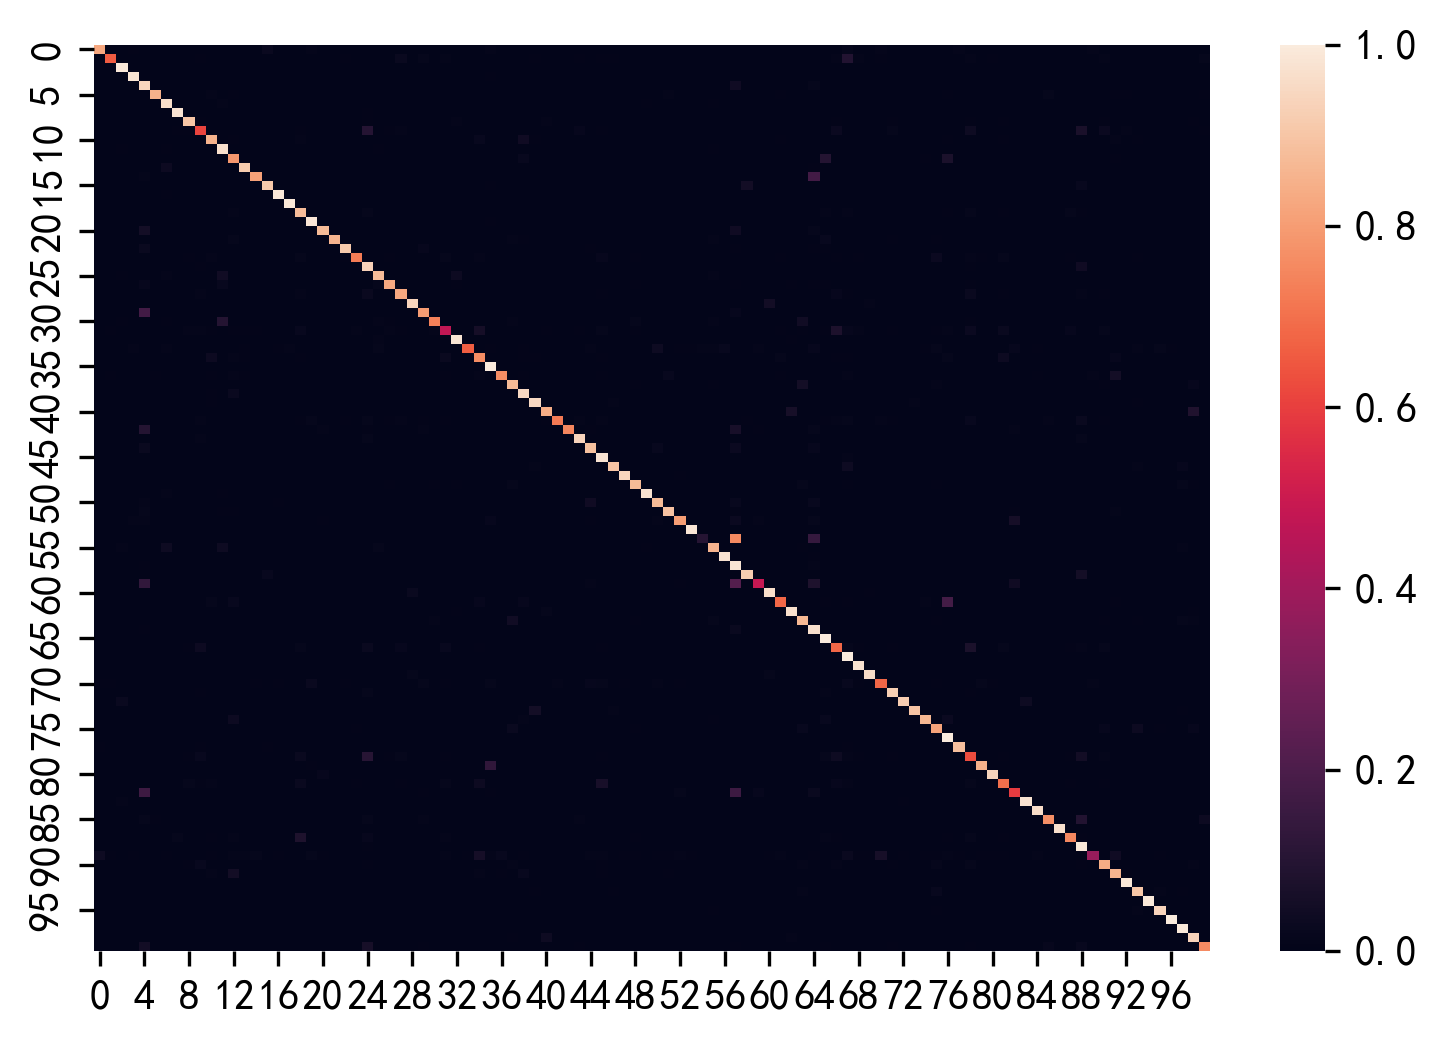

In [140]:
plt.figure(dpi=300)
sns.heatmap(th.softmax(th.from_numpy(sim_matrix / 0.02), dim=1))

In [90]:
lang_start = []
start = 0
for idx in range(len(langs)):
    lang_start.append(start)
    start += len(dataset.datasets[idx])
lang_start.append(start)

In [147]:
de_t_labels = t_labels[lang_start[0] : lang_start[1]]
other_lang_idx = 6
other_t_labels = t_labels[lang_start[other_lang_idx] : lang_start[other_lang_idx + 1]]
plot_langs = ['de'] * len(de_t_labels) + [langs[other_lang_idx]] * len(other_t_labels)

In [148]:
plot_df = pd.DataFrame()
plot_df['label'] = np.concatenate([de_t_labels, other_t_labels])
plot_df['lang'] = plot_langs

<Figure size 3000x2000 with 0 Axes>

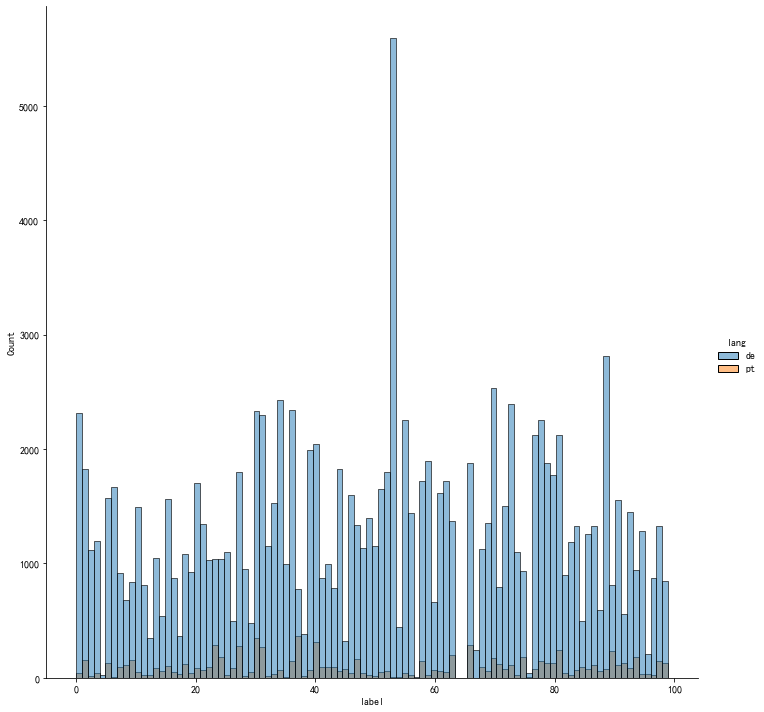

In [149]:
plt.figure(dpi=500)
sns.displot(plot_df, x='label', hue='lang', bins=100, height=10)

# Obtain ST Model Features

## Build Dataset

In [10]:
data_cfg = MultilingualTripletDataConfig(os.path.join(data_root, 'config_mST.yaml'))

In [11]:
tokenizer = encoders.build_bpe(
    Namespace(**data_cfg.bpe_tokenizer)
)

In [12]:
codes = MultilingualTripletDataset.get_lang_codes(data_cfg.lang_list_filename)

def load_dict(vocab_filename):
    _dict_path = os.path.join(data_root, vocab_filename)
    if not os.path.isfile(_dict_path):
        raise FileNotFoundError(f"Dict not found: {_dict_path}")
    _dict = Dictionary.load(_dict_path)
    for code in codes:
        _dict.add_symbol(MultilingualTripletDataset.LANG_TAG_TEMPLATE.format(code))
    _dict.add_symbol('<mask>')
    return _dict

tgt_dict = load_dict(data_cfg.vocab_filename)
src_dict = load_dict(data_cfg.src_vocab_filename)

In [13]:
splits = ''
for lang in langs:
    splits = splits + '{}_en_train,'.format(lang)
splits = splits[:-1]

In [14]:
dataset = MultilingualTripletDatasetCreator.from_tsv(
    data_root, 
    data_cfg,
    splits ,
    tgt_dict,
    src_dict,
    None,
    tokenizer,
    tokenizer,
    True,
    epoch=1,
    seed=1,
    normalize=False,
    sample_rate=16000
)

In [15]:
th.cuda.empty_cache()

In [23]:
bsz = 10
x = []
with th.inference_mode():
    for i in tqdm(range(0, len(dataset), bsz)):
        limit = min(bsz, len(dataset) - i)
        samples = [dataset[i + j] for j in range(limit)]
        input = dataset.collater(samples)
        encoder_out = st_model.encoder(input['src_text'].to('cuda'), input['src_text_lengths'].to('cuda'))
        lengths = padding_mask_to_lengths(encoder_out.encoder_padding_mask)
        for j in range(limit):
            x.append(encoder_out.encoder_out[:lengths[j], j].mean(dim=0).cpu())

100%|██████████| 55548/55548 [17:19<00:00, 53.45it/s]


In [24]:
x = th.stack(x).numpy()

## Cluster for Speech Features

In [25]:
n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, verbose=1, n_init=3)
labels = kmeans.fit_predict(x)
np.save('{}_mt_labels.npy'.format(st_model_tag), labels)
n_labels = np.array([(labels == i).sum() for i in range(n_clusters)])

Initialization complete
Iteration 0, inertia 39596500.0
Iteration 1, inertia 25001806.0
Iteration 2, inertia 24549404.0
Iteration 3, inertia 24366346.0
Iteration 4, inertia 24248942.0
Iteration 5, inertia 24155550.0
Iteration 6, inertia 24102276.0
Iteration 7, inertia 24074318.0
Iteration 8, inertia 24058604.0
Iteration 9, inertia 24046322.0
Iteration 10, inertia 24037328.0
Iteration 11, inertia 24029908.0
Iteration 12, inertia 24023188.0
Iteration 13, inertia 24016108.0
Iteration 14, inertia 24008574.0
Iteration 15, inertia 24001712.0
Iteration 16, inertia 23996156.0
Iteration 17, inertia 23991694.0
Iteration 18, inertia 23988434.0
Iteration 19, inertia 23985830.0
Iteration 20, inertia 23983714.0
Iteration 21, inertia 23981912.0
Iteration 22, inertia 23980500.0
Iteration 23, inertia 23979418.0
Iteration 24, inertia 23978612.0
Iteration 25, inertia 23977984.0
Iteration 26, inertia 23977462.0
Iteration 27, inertia 23977086.0
Iteration 28, inertia 23976750.0
Iteration 29, inertia 2397647

In [26]:
de_labels = labels[:len(dataset.datasets[0])]
fr_labels = labels[len(dataset.datasets[0]):len(dataset.datasets[0]) + len(dataset.datasets[1])]

In [27]:
plot_langs = ['de'] * len(de_labels) + ['fr'] * len(fr_labels)

In [28]:
plot_df = pd.DataFrame()
plot_df['label'] = np.concatenate([de_labels, fr_labels])
plot_df['lang'] = plot_langs

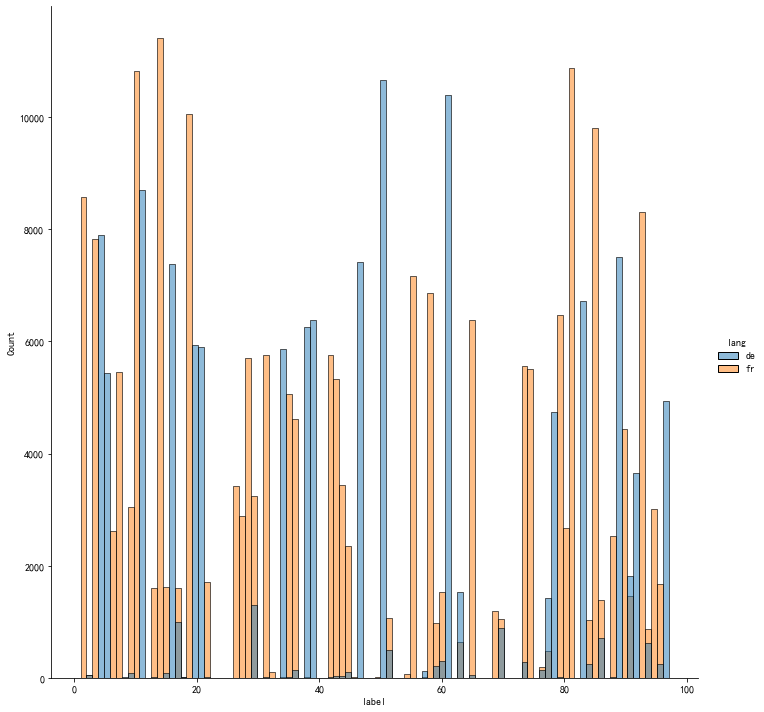

In [29]:
sns.displot(plot_df, x='label', hue='lang', bins=100, height=10)